### Prototype code to slide though a dataframe of activities and select columns for feature engineering  

We start from a dataframe that includes all activities done by all subjects at all times. We want to create time slices of a specified length for each activity and then calculate statistical properties of the feature columns for those slices. We need to ensure that each slice corresponds to one subject doing one activity.

In [1]:
import pandas as pd
import numpy as np
from FeatureCalculate import FeatureCalc

In [2]:
all_data = pd.read_csv("All_subject_data.csv")

In [3]:
all_data.head()

,timestamp,activityID,heart_rate,hand_temp,hand_acc16g_x,hand_acc16g_y,hand_acc16g_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,...,ankle_acc16g_x,ankle_acc16g_y,ankle_acc16g_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,subject
0,18.38,0,101.0,30.125,2.38774,8.71824,3.93367,0.038604,-0.019512,-0.016600,...,9.77606,-1.61971,0.055537,0.013482,0.007882,0.021020,-60.8641,-38.6290,-59.0093,1.0
1,18.39,0,101.0,30.125,2.50057,8.83085,3.89650,0.032395,-0.018320,0.000070,...,9.73604,-1.69477,-0.021587,0.001074,-0.005661,0.005893,-60.7469,-38.8570,-58.7652,1.0
2,18.40,0,101.0,30.125,2.23391,8.71874,3.85439,0.019831,0.013608,-0.016611,...,9.73184,-1.65552,-0.176232,-0.004727,-0.029526,0.032437,-60.7410,-38.4355,-57.2754,1.0
3,18.41,0,101.0,30.125,2.12001,8.64374,3.85294,0.024886,0.012792,-0.019079,...,9.69661,-1.65592,-0.099411,0.004934,-0.016553,-0.010741,-60.5084,-39.3196,-57.7818,1.0
4,18.42,0,101.0,30.125,2.20280,8.72071,4.04636,0.009752,-0.016007,0.007369,...,9.50968,-1.61677,-0.101571,0.012817,-0.038506,0.012706,-59.9536,-38.7909,-57.5332,1.0


In [4]:
from Feature_calc_test import *

In [5]:
all_data = select_data_to_process(all_data)

### Feature calculation is quite slow. We'll test it first just with a single subject

Might be worth trying to make this more efficient?

In [6]:
all_data = all_data[all_data['subject'] == 6]

In [7]:
feature_df = calculate_features(all_data)


-------------------------------
Subject 6.0
[(0, 21339), (21340, 42380), (42381, 64736), (64737, 100480), (100481, 119558), (119559, 123790), (123791, 127963), (127964, 133022), (133023, 136121), (136122, 159842), (159843, 184528), (184529, 203014), (203015, 223839), (223840, 283616), (283617, 310330), (310331, 330117)]
Activity 1.000000
Length of slice in samples: 21340
Number of feature calculations to be done: 208
Activity 2.000000
Length of slice in samples: 21041
Number of feature calculations to be done: 205
Activity 3.000000
Length of slice in samples: 22356
Number of feature calculations to be done: 218
Activity 17.000000
Length of slice in samples: 35744
Number of feature calculations to be done: 352
Activity 16.000000
Length of slice in samples: 19078
Number of feature calculations to be done: 185
Activity 12.000000
Length of slice in samples: 4232
Number of feature calculations to be done: 37
Activity 13.000000
Length of slice in samples: 4173
Number of feature calculations

In [10]:
list(feature_df.columns)

['timestamp_mean',
 'activityID_mean',
 'heart_rate_mean',
 'hand_temp_mean',
 'hand_acc16g_x_mean',
 'hand_acc16g_y_mean',
 'hand_acc16g_z_mean',
 'hand_gyro_x_mean',
 'hand_gyro_y_mean',
 'hand_gyro_z_mean',
 'hand_mag_x_mean',
 'hand_mag_y_mean',
 'hand_mag_z_mean',
 'chest_temp_mean',
 'chest_acc16g_x_mean',
 'chest_acc16g_y_mean',
 'chest_acc16g_z_mean',
 'chest_gyro_x_mean',
 'chest_gyro_y_mean',
 'chest_gyro_z_mean',
 'chest_mag_x_mean',
 'chest_mag_y_mean',
 'chest_mag_z_mean',
 'ankle_temp_mean',
 'ankle_acc16g_x_mean',
 'ankle_acc16g_y_mean',
 'ankle_acc16g_z_mean',
 'ankle_gyro_x_mean',
 'ankle_gyro_y_mean',
 'ankle_gyro_z_mean',
 'ankle_mag_x_mean',
 'ankle_mag_y_mean',
 'ankle_mag_z_mean',
 'subject_mean',
 'heart_rate_median',
 'hand_temp_median',
 'hand_acc16g_x_median',
 'hand_acc16g_y_median',
 'hand_acc16g_z_median',
 'hand_gyro_x_median',
 'hand_gyro_y_median',
 'hand_gyro_z_median',
 'hand_mag_x_median',
 'hand_mag_y_median',
 'hand_mag_z_median',
 'chest_temp_media

Faster option - look for breaks in activity within subject and then take those timeseries and chunk them

In [21]:
dt = 0.01 #sample rate in seconds
sliding_window_length = 512 #window length in samples
sliding_window_offset = 100 #offset between windows in samples
#Values from Reiss (2012)


nslices_estimate = int(np.floor((len(all_data)-sliding_window_length)/sliding_window_offset))
features = ['mean','median','std','peak']
cols = all_data.columns

feature_cols = []
for featurename in features:
    for name in cols:
        newname = '%s_%s' %(name,featurename)
        feature_cols.append(newname)

feature_cols = feature_cols 
print(len(feature_cols))

ncols = len(feature_cols)

#Define featurecalc object
f = FeatureCalc(ncols)

#We wil fill the feature matrix and then turn it into a dataframe because we 
#have already generated the column names. If there are extra nans we will just remove them
#at the end
feature_matrix = np.full((nslices_estimate,ncols),np.nan)

rowcount=0

for subjectID in all_data['subject'].unique():
    
    print('\n-------------------------------')
    print('Subject %s' %subjectID)
    
    subjectDF = all_data[all_data['subject'] == subjectID]
    subjectDF.reset_index(inplace=True,drop=True)
      
    #Detect changes in activity ID
    activities = subjectDF['activityID']
    diffs = np.diff(activities)
    gap_indices = np.where(abs(diffs)>1e-6)[0]
    
    #Generate a list of the start and end indices of each activity
    gap_indices_list = []

    if len(gap_indices > 0):
        for i in range(len(gap_indices)):
            if i == 0:
                gap_indices_list.append((0,gap_indices[i]))
            else:
                gap_indices_list.append((gap_indices[i-1]+1,gap_indices[i]))
                
        gap_indices_list.append((gap_indices[-1]+1,len(subjectDF)))
    else:
        gap_indices_list.append((0,len(subjectDF)))
            
    print(gap_indices_list)

    for index_pair in gap_indices_list:

        constant_activity_slice = subjectDF.loc[index_pair[0]:index_pair[1]]
        constant_activity_slice.reset_index(inplace=True,drop=True)
        #print(constant_dt_slice['timestamp'].is_monotonic)
        
        print('Activity %f' %np.mean(constant_activity_slice['activityID']))

        #Check if the slice that we've made has enough samples to calculate features

        if len(constant_activity_slice) < sliding_window_length:
            print("Not enough points to create slice of length %i" %sliding_window_length)

        else:

            #Move though the slice in this number of units. We will lose some data
            #at the end of each constant_dt_slice dataframe because we must take an integer
            #number of steps 

            nslices = int(np.floor((len(constant_activity_slice)-sliding_window_length)/sliding_window_offset))

            print("Length of slice in samples: %i" %len(constant_activity_slice))
            print("Number of feature calculations to be done: %i" %nslices)

            t1 = 0
            for j in range(nslices):
                t2 = t1 + sliding_window_length - 1
                #print(t1,t2)
                
                feature_slice = constant_activity_slice.loc[t1:t2]
                    
                if (abs(np.mean(np.diff(feature_slice['timestamp']))) - dt > 1e-6):
                    print("Error in slicing gap indices! Data chunk is not sampled at constant dt!")
                
                else:

                    # This is the dataframe on which we will calculate statistical features
                    #feature_slice.drop(['timestamp'],axis=1,inplace=True)
                    
                    f.load_new_ts(feature_slice)
                    data = f.calculate_features()
                    
                    feature_matrix[rowcount,:] = data
                    rowcount+=1
                

                t1 = t1 + sliding_window_offset
                #print(len(feature_slice))
                
           

136

-------------------------------
Subject 6.0
[(0, 21339), (21340, 42380), (42381, 64736), (64737, 100480), (100481, 119558), (119559, 123790), (123791, 127963), (127964, 133022), (133023, 136121), (136122, 159842), (159843, 184528), (184529, 203014), (203015, 223839), (223840, 283616), (283617, 310330), (310331, 330117)]
Activity 1.000000
Length of slice in samples: 21340
Number of feature calculations to be done: 208
Activity 2.000000
Length of slice in samples: 21041
Number of feature calculations to be done: 205
Activity 3.000000
Length of slice in samples: 22356
Number of feature calculations to be done: 218
Activity 17.000000
Length of slice in samples: 35744
Number of feature calculations to be done: 352
Activity 16.000000
Length of slice in samples: 19078
Number of feature calculations to be done: 185
Activity 12.000000
Length of slice in samples: 4232
Number of feature calculations to be done: 37
Activity 13.000000
Length of slice in samples: 4173
Number of feature calculat

In [72]:
len(feature_cols)

136

In [73]:
np.shape(feature_matrix)

(3296, 136)

In [74]:
feature_df = pd.DataFrame(feature_matrix,columns=feature_cols)

In [75]:
len(feature_df)

3296

In [76]:
feature_df.dropna(inplace=True)

In [77]:
feature_df.reset_index(inplace=True,drop=True)

In [78]:
len(feature_df)

3212

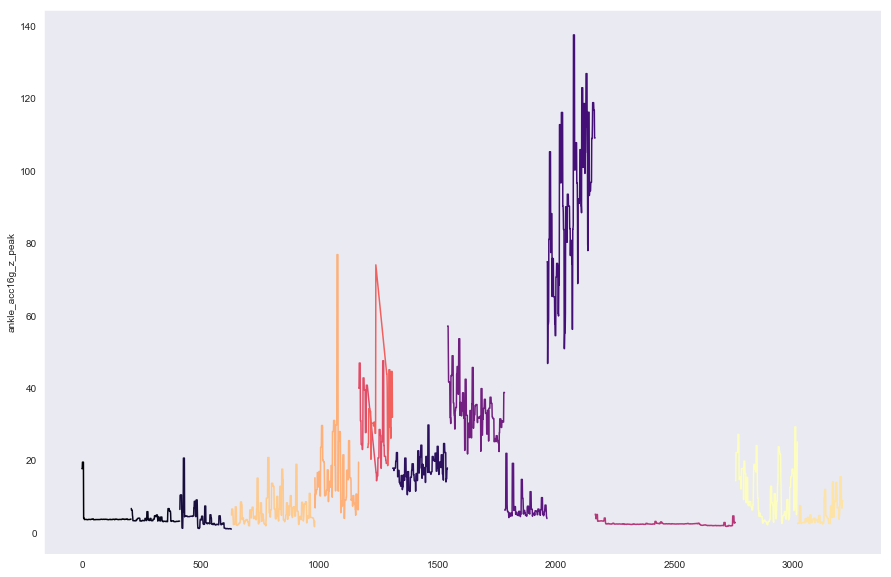

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style('darkgrid')
X = np.arange(len(feature_df))
f = plt.figure(figsize=(15,10))
sns.lineplot(x=X,y=feature_df['ankle_acc16g_z_peak'],hue=feature_df['activityID_peak'],palette='magma',legend=None)
plt.grid()
#feature_df['heart_rate_mean'].plot()
#feature_df['ankle_acc16g_z_peak'].plot()
#feature_df['activityID_mean'].plot()

#### Demonstrating plots with different scales

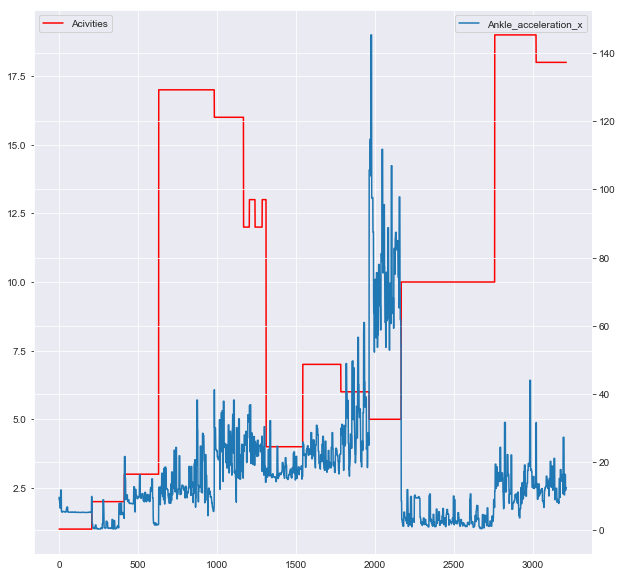

In [106]:
fig, ax1 = plt.subplots(figsize=(10,10))
X = np.array(feature_df.index)
Y1 = feature_df['activityID_mean'].values
Y2 = feature_df['hand_acc16g_x_peak'].values
ax1.plot(X,Y1,'r-',label='Acivities')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(X,Y2,label='Ankle_acceleration_x')
ax2.legend(loc='upper right')


The relationship is complex! But there are definitey noticable differences between activities that might be useful when it comes to discriminating
between them

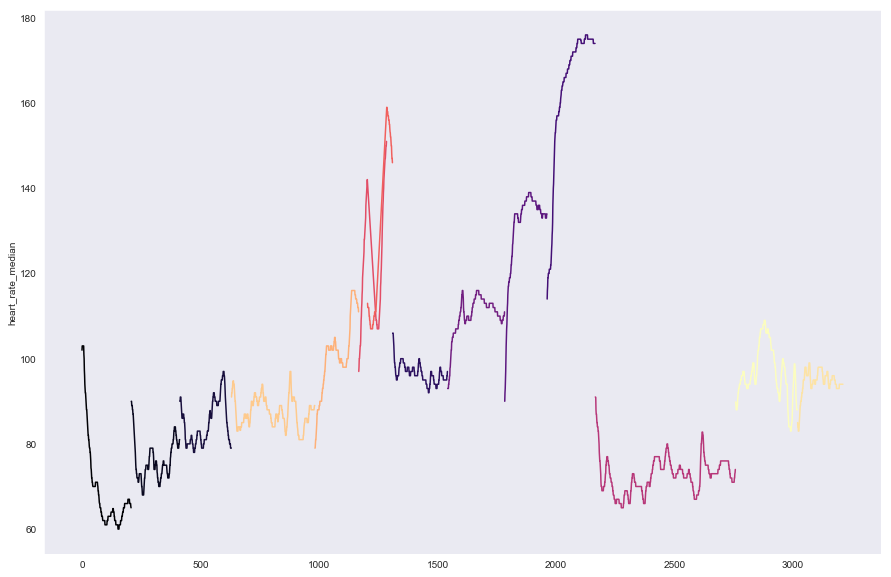

In [80]:
X = np.arange(len(feature_df))
f = plt.figure(figsize=(15,10))
sns.lineplot(x=list(feature_df.index),y=feature_df['heart_rate_median'],hue=feature_df['activityID_peak'],palette='magma',legend=None)
plt.grid()

In [81]:
feature_df['activityID_mean'].unique()

array([ 1.,  2.,  3., 17., 16., 12., 13.,  4.,  7.,  6.,  5., 10., 19.,
       18.])

In [113]:
all_data.columns[3:-1]

Index(['hand_temp', 'hand_acc16g_x', 'hand_acc16g_y', 'hand_acc16g_z',
       'hand_gyro_x', 'hand_gyro_y', 'hand_gyro_z', 'hand_mag_x', 'hand_mag_y',
       'hand_mag_z', 'chest_temp', 'chest_acc16g_x', 'chest_acc16g_y',
       'chest_acc16g_z', 'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z',
       'chest_mag_x', 'chest_mag_y', 'chest_mag_z', 'ankle_temp',
       'ankle_acc16g_x', 'ankle_acc16g_y', 'ankle_acc16g_z', 'ankle_gyro_x',
       'ankle_gyro_y', 'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y',
       'ankle_mag_z'],
      dtype='object')

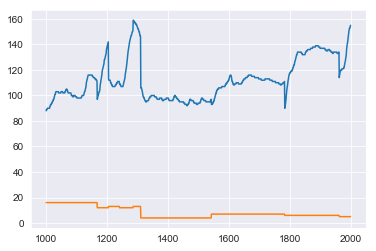

In [82]:
feature_df['heart_rate_median'].loc[1000:2000].plot()
feature_df['activityID_mean'].loc[1000:2000].plot()

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

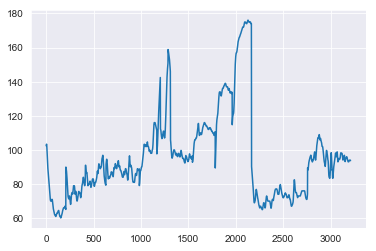

In [84]:
feature_df['heart_rate_mean'].plot()

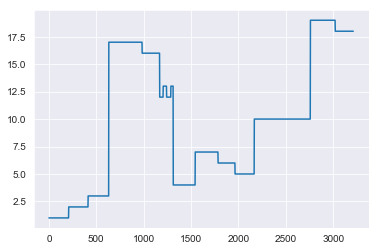

In [85]:
feature_df['activityID_mean'].plot()

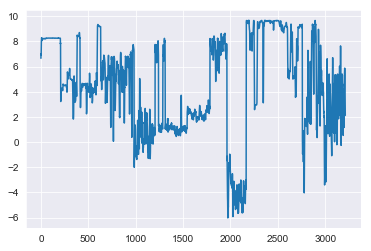

In [86]:
feature_df['hand_acc16g_z_mean'].plot()

In [8]:
np.diff(time_values )

array([0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01])

In [10]:
time_values.

AttributeError: 'Series' object has no attribute 'is_increasing'

In [82]:
feature_slice.head()

,timestamp,activityID,heart_rate,hand_temp,hand_acc16g_x,hand_acc16g_y,hand_acc16g_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,...,ankle_acc16g_x,ankle_acc16g_y,ankle_acc16g_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,subject
26200,1920.30,20,181.0,24.875,-6.27358,0.260696,0.98440,-0.996684,1.13452,3.03701,...,11.4670,-0.318083,-2.55929,-0.410484,-0.019082,-1.59836,-35.1120,-15.8728,13.2171,9.0
26201,1920.31,20,181.0,24.875,-6.04523,-0.270862,1.14356,-0.878315,1.18428,2.76692,...,11.8801,-0.473208,-2.47691,-0.375769,0.018132,-1.78777,-35.0925,-16.6454,13.5017,9.0
26202,1920.32,20,181.0,24.875,-6.01037,-0.877846,1.18462,-0.841679,1.23973,2.39317,...,12.9188,-0.553214,-2.77448,-0.381020,0.080768,-1.94002,-34.4409,-17.5808,12.9378,9.0
26203,1920.33,20,181.0,24.875,-6.48665,-1.211150,1.67895,-0.837649,1.27904,2.00093,...,13.8256,-0.181146,-2.53595,-0.358763,0.075320,-2.13300,-34.6952,-17.6973,12.7952,9.0
26204,1920.34,20,181.0,24.875,-6.89859,-1.055510,1.74923,-0.816204,1.33431,1.60023,...,13.5014,-0.296773,-2.07549,-0.407874,0.074267,-2.30723,-33.4047,-18.5349,12.5170,9.0


In [120]:
all_data.columns

Index(['timestamp', 'activityID', 'heart_rate', 'hand_temp', 'hand_acc16g_x',
       'hand_acc16g_y', 'hand_acc16g_z', 'hand_gyro_x', 'hand_gyro_y',
       'hand_gyro_z', 'hand_mag_x', 'hand_mag_y', 'hand_mag_z', 'chest_temp',
       'chest_acc16g_x', 'chest_acc16g_y', 'chest_acc16g_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'ankle_temp', 'ankle_acc16g_x', 'ankle_acc16g_y',
       'ankle_acc16g_z', 'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z',
       'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z', 'subject'],
      dtype='object')

In [6]:
from FeatureCalculate import FeatureCalc

In [7]:
f = FeatureCalc()
f.load_new_ts(feature_slice)

In [9]:
df = f.calculate_features()
df.head()

,timestamp_mean,activityID_mean,heart_rate_mean,hand_temp_mean,hand_acc16g_x_mean,hand_acc16g_y_mean,hand_acc16g_z_mean,hand_gyro_x_mean,hand_gyro_y_mean,hand_gyro_z_mean,...,ankle_acc16g_x_max,ankle_acc16g_y_max,ankle_acc16g_z_max,ankle_gyro_x_max,ankle_gyro_y_max,ankle_gyro_z_max,ankle_mag_x_max,ankle_mag_y_max,ankle_mag_z_max,subject_max
0,1922.855,20.0,181.0,24.910278,-11.46982,3.739023,1.199573,0.028134,0.18802,-0.080533,...,34.7325,40.564,16.723,4.42687,1.29571,8.25083,-1.74316,15.3272,27.8228,9.0


In [84]:
colnames = [col+'_min' for col in feature_slice.min().index]
pd.DataFrame(np.reshape(feature_slice.min().values,(1,len(feature_slice.min()))),columns=colnames)

,timestamp_min,activityID_min,heart_rate_min,hand_temp_min,hand_acc16g_x_min,hand_acc16g_y_min,hand_acc16g_z_min,hand_gyro_x_min,hand_gyro_y_min,hand_gyro_z_min,...,ankle_acc16g_x_min,ankle_acc16g_y_min,ankle_acc16g_z_min,ankle_gyro_x_min,ankle_gyro_y_min,ankle_gyro_z_min,ankle_mag_x_min,ankle_mag_y_min,ankle_mag_z_min,subject_min
0,1920.3,20.0,181.0,24.875,-17.1784,-4.92285,-2.15534,-5.12144,-1.44073,-4.84119,...,-2.56344,-43.1826,-23.5427,-3.96883,-1.62229,-4.28603,-42.4468,-39.0253,8.32693,9.0


In [34]:
constant_activity_slice.reset

,index,timestamp,activityID,heart_rate,hand_temp,hand_acc16g_x,hand_acc16g_y,hand_acc16g_z,hand_acc6g_x,hand_acc6g_y,...,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,ankle_ori_0,ankle_ori_1,ankle_ori_2,ankle_ori_3,subject
0,165219,1658.30,20,107.0,25.1250,-6.58160,4.38968,-0.034815,-6.56650,4.30759,...,0.340672,2.247710,-33.9847,-29.073100,9.12322,0.542232,-0.545912,0.619634,-0.154978,9.0
1,165220,1658.31,20,107.0,25.1250,-6.83542,4.01569,0.347518,-6.59337,4.38359,...,0.561841,2.533430,-35.6566,-28.604400,8.83313,0.540577,-0.538959,0.624517,-0.165160,9.0
2,165221,1658.32,20,107.0,25.1250,-7.28648,3.79256,0.456977,-6.84971,4.14402,...,0.699906,2.604020,-36.5807,-27.142100,8.82818,0.541538,-0.529228,0.629862,-0.172999,9.0
3,165222,1658.33,20,107.0,25.1250,-8.04040,3.68525,0.523021,-7.37935,3.83075,...,0.319241,2.511900,-36.5975,-26.498400,8.54371,0.539209,-0.522132,0.635233,-0.181964,9.0
4,165223,1658.34,20,107.0,25.1250,-9.02159,3.50381,0.585910,-8.28397,3.70144,...,0.235147,2.317260,-36.7424,-25.459900,8.96750,0.532810,-0.519630,0.638872,-0.194783,9.0
5,165224,1658.35,20,107.0,25.1250,-9.96365,3.51178,0.648747,-9.24800,3.60284,...,0.373509,2.206880,-38.0259,-24.879700,9.38780,0.525895,-0.518186,0.641337,-0.208817,9.0
6,165225,1658.36,20,107.0,25.1250,-10.59140,3.70979,1.023550,-10.14970,3.63981,...,0.376696,2.045720,-38.0306,-23.844900,10.94670,0.519112,-0.516992,0.643577,-0.221472,9.0
7,165226,1658.37,20,107.0,25.1250,-11.14510,3.67958,1.400230,-10.82530,3.66007,...,0.322390,1.993880,-38.6853,-23.428100,10.23480,0.511712,-0.516357,0.645258,-0.234880,9.0
8,165227,1658.38,20,107.0,25.1250,-11.09530,3.68231,1.747350,-11.21390,3.64814,...,0.422821,1.829050,-39.3532,-21.719400,10.79780,0.505065,-0.515655,0.646308,-0.247580,9.0
9,165228,1658.39,20,107.0,25.1250,-10.90230,3.49250,1.904830,-11.24280,3.54287,...,0.426957,1.445680,-39.9872,-21.686500,11.22100,0.499278,-0.515653,0.646498,-0.258579,9.0


In [36]:
subjectDF.head()

,index,timestamp,activityID,heart_rate,hand_temp,hand_acc16g_x,hand_acc16g_y,hand_acc16g_z,hand_acc6g_x,hand_acc6g_y,...,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,ankle_ori_0,ankle_ori_1,ankle_ori_2,ankle_ori_3,subject
0,2573,41.20,24,142.0,24.9375,-2.580050,-8.11327,-2.97320,-2.101910,-5.10911,...,-0.373266,0.143938,-37.7896,-22.9544,11.3721,0.536338,-0.573378,0.576626,-0.226013,9.0
1,2574,41.21,24,142.0,24.9375,-0.203604,-7.60252,-3.17025,-2.147390,-8.17168,...,-0.295663,0.428712,-37.6794,-22.0583,11.5132,0.534140,-0.573457,0.577939,-0.227655,9.0
2,2575,41.22,24,142.0,24.9375,0.429395,-4.58005,-4.05617,-0.255044,-7.08296,...,-0.176065,0.707483,-37.1587,-22.4701,11.6574,0.533091,-0.571351,0.580563,-0.228733,9.0
3,2576,41.23,24,142.0,24.9375,0.162534,-3.08203,-2.25632,0.143441,-4.54861,...,-0.052508,0.951131,-38.0762,-21.3948,11.5111,0.534009,-0.566646,0.584206,-0.229018,9.0
4,2577,41.24,24,142.0,24.9375,0.424853,-3.71869,-1.09562,0.074481,-3.51972,...,0.093691,1.212760,-38.4364,-22.5359,11.3693,0.536356,-0.559696,0.588779,-0.228913,9.0
